<a href="https://colab.research.google.com/github/miky0020/mikhay/blob/main/Mikhay_Optic_Disc_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [87]:
from google.colab import files
f = files.upload()

Saving WhatsApp Image 2026-01-30 at 22.46.15.jpeg to WhatsApp Image 2026-01-30 at 22.46.15 (4).jpeg


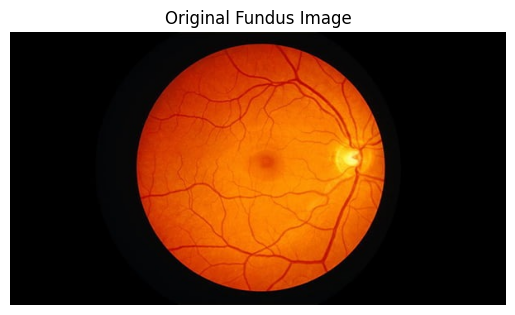

In [110]:


# Load image
filename = 'WhatsApp Image 2026-01-30 at 22.46.15 (4).jpeg'
img_bgr = cv2.imread(filename)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title("Original Fundus Image")
plt.axis('off')
plt.show()

In [111]:

#Cropped Image for Optic Disc Segmentation

#The paper uses Equations 6–10 to calculate a rectangle window size (WI=Width/2, HI=Height/2) centered on the localized point.# 1. Localization (Find the brightest point in Red channel)
red_full = img_rgb[:,:,0]
red_blur = cv2.GaussianBlur(red_full, (51, 51), 0)
_, _, _, maxLoc = cv2.minMaxLoc(red_blur)

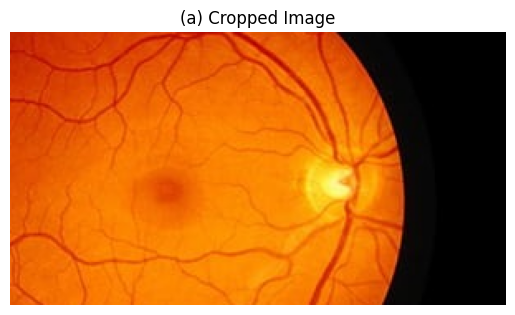

In [112]:
# 2. Cropping
ir, ic, _ = img_rgb.shape
wi, hi = ic // 2, ir // 2
x_start = max(0, int(maxLoc[0] - (wi // 2)))
y_start = max(0, int(maxLoc[1] - (hi // 2)))
cropped_img = img_rgb[y_start:y_start+hi, x_start:x_start+wi]

plt.imshow(cropped_img)
plt.title("(a) Cropped Image")
plt.axis('off')
plt.show()

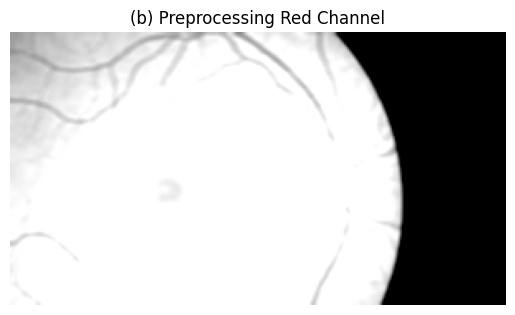

In [113]:
#Preprocessing done on Red Channel

#This step applies a circular averaging filter (disk value = 5), selects the red channel, and performs binarization. 1. Circular averaging filter (disk = 5)
disk_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
disk_kernel = disk_kernel / disk_kernel.sum()
smooth_crop = cv2.filter2D(cropped_img, -1, disk_kernel)

# 2. Red channel selection and adjustment (0.5 to 0.9)
red_ch = smooth_crop[:,:,0].astype(float) / 255.0
red_adj = np.clip((red_ch - 0.5) / 0.4, 0, 1)

# 3. Binarization (Otsu)
red_adj_u8 = (red_adj * 255).astype(np.uint8)
_, mask = cv2.threshold(red_adj_u8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
masked_rgb = cv2.bitwise_and(cropped_img, cropped_img, mask=mask)

plt.imshow(red_adj, cmap='gray')
plt.title("(b) Preprocessing Red Channel")
plt.axis('off')
plt.show()

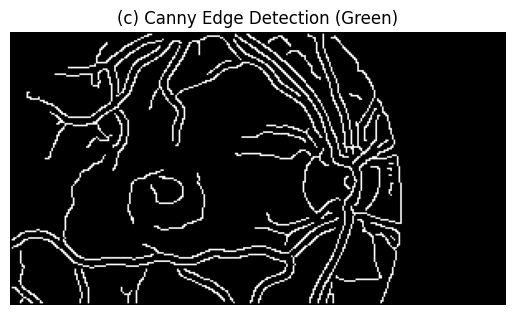

In [114]:
#Canny Edge Detection on Green Channel

#The green channel is selected, adjusted (0.2 to 0.8), blurred with a Gaussian filter (σ=2), and then processed with Canny.
# Green channel selection and adjustment
green_ch = masked_rgb[:,:,1].astype(float) / 255.0
green_adj = np.clip((green_ch - 0.2) / 0.6, 0, 1)
green_blur = cv2.GaussianBlur(green_adj, (5, 5), 2)

# Canny Edge
edges = canny(green_blur, sigma=1)

plt.imshow(edges, cmap='gray')
plt.title("(c) Canny Edge Detection (Green)")
plt.axis('off')
plt.show()

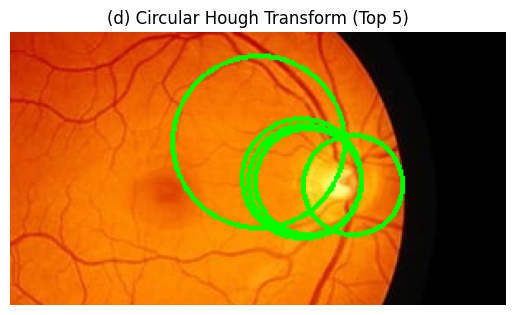

In [115]:
#Circular Hough Transform (Peak = 5)

#The CHT is applied to find circular shapes within the edge map. The paper specifies selecting the top 5 peaks.# Search radius range from paper: typically 30 to 55 for most datasets
#hough_radii = np.arange(30, 60, 2)
#hough_res = hough_circle(edges, hough_radii)
#accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=5)

# Visualize peaks on cropped image
cht_viz = cropped_img.copy()
for i in range(len(radii)):
    cv2.circle(cht_viz, (cx[i], cy[i]), radii[i], (0, 255, 0), 2)

plt.imshow(cht_viz)
plt.title("(d) Circular Hough Transform (Top 5)")
plt.axis('off')
plt.show()

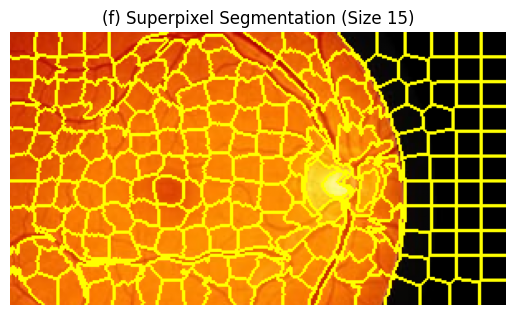

In [116]:
#Red Channel Selection & Superpixel Segmentation

#Stage 2 involves selecting the red channel again and performing SLIC superpixel segmentation with a region size of 15.# (e) Red channel selection
#red_stage2 = cropped_img[:,:,0]

# (f) Superpixel segmentation (Region size = 15)
n_seg = (cropped_img.shape[0] * cropped_img.shape[1]) // (15 * 15)
segments = slic(cropped_img, n_segments=n_seg, compactness=10, start_label=1)
superpixel_viz = mark_boundaries(cropped_img, segments)

plt.imshow(superpixel_viz)
plt.title("(f) Superpixel Segmentation (Size 15)")
plt.axis('off')
plt.show()

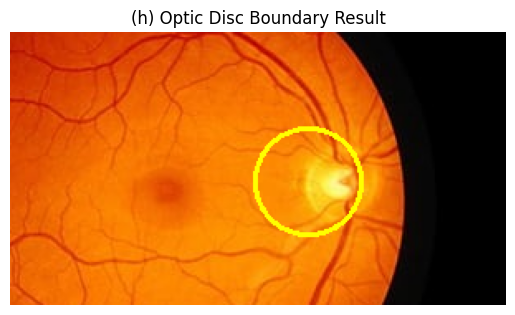

In [117]:
#Final Optic Disc Boundary
#The paper uses the superpixel information to cross-validate and refine the Circular Hough Transform result.
# (h) Final Optic Disc boundary
final_boundary = cropped_img.copy()
if len(radii) > 0:
    # Use the strongest peak (index 0)
    cv2.circle(final_boundary, (cx[0], cy[0]), radii[0], (255, 255, 0), 2)

plt.imshow(final_boundary)
plt.title("(h) Optic Disc Boundary Result")
plt.axis('off')
plt.show()